<a href="https://www.kaggle.com/code/lisphilar/eda-of-japan-dataset?scriptVersionId=103217273" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

This notebook is just inroduction of "COVID-19 dataset in Japan" and shows the contents of this dataset.

In [1]:
from datetime import datetime
time_format = "%d%b%Y %H:%M"
datetime.now().strftime(time_format)

'13Aug2022 15:48'

In [2]:
from pprint import pprint
import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import ScalarFormatter
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 1000)

plt.style.use("seaborn-ticks")
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["font.size"] = 11.0
plt.rcParams["figure.figsize"] = (9, 6)

In [3]:
!pip install japanmap
import japanmap

     |████████████████████████████████| 167 kB 4.3 MB/s 
  Created wheel for japanmap: filename=japanmap-0.0.21-py3-none-any.whl size=166793 sha256=f608a723be0838f66ebedbca33870fe65302a3465690e82513b59cca8154d2dc
  Stored in directory: /root/.cache/pip/wheels/fe/27/1a/f97135403d1bcba8dbf37280d2da510532c136bcf1c9ac123b
Successfully built japanmap


In [4]:
def line_plot(df, title, ylabel="Cases", h=None, v=None,
              xlim=(None, None), ylim=(0, None), math_scale=True, y_logscale=False, y_integer=False):
    """
    Show chlonological change of the data.
    """
    ax = df.plot()
    if math_scale:
        ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
        ax.ticklabel_format(style="sci",  axis="y",scilimits=(0, 0))
    if y_logscale:
        ax.set_yscale("log")
    if y_integer:
        fmt = matplotlib.ticker.ScalarFormatter(useOffset=False)
        fmt.set_scientific(False)
        ax.yaxis.set_major_formatter(fmt)
    ax.set_title(title)
    ax.set_xlabel(None)
    ax.set_ylabel(ylabel)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.legend(bbox_to_anchor=(1.02, 0), loc="lower left", borderaxespad=0)
    if h is not None:
        ax.axhline(y=h, color="black", linestyle="--")
    if v is not None:
        if not isinstance(v, list):
            v = [v]
        for value in v:
            ax.axvline(x=value, color="black", linestyle="--")
    plt.tight_layout()
    plt.show()

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/covid19-dataset-in-japan/covid_jpn_prefecture.csv
/kaggle/input/covid19-dataset-in-japan/covid_jpn_total.csv
/kaggle/input/covid19-dataset-in-japan/covid_jpn_metadata.csv


# Cumurative number of cases
covid_jpn_total.csv

## Raw data

In [6]:
ncov_raw = pd.read_csv("/kaggle/input/covid19-dataset-in-japan/covid_jpn_total.csv")
ncov_raw.tail()

,Date,Location,Positive,Tested,Symptomatic,Asymptomatic,Sym-unknown,Hosp_require,Hosp_mild,Hosp_severe,Hosp_unknown,Hosp_waiting,Discharged,Fatal,Vaccinated_1st,Vaccinated_2nd,Vaccinated_3rd
2717,2022-08-12,Airport,20973,2332931.0,NaN,NaN,NaN,240.0,NaN,0,NaN,NaN,20725,8,0.0,0.0,0.0
2718,2022-08-12,Returnee,15,829.0,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,15,0,0.0,0.0,0.0
2719,2022-08-13,Domestic,15257647,64129801.0,NaN,NaN,NaN,1965594.0,NaN,625,NaN,NaN,13185178,34755,0.0,0.0,0.0
2720,2022-08-13,Airport,21006,2333469.0,NaN,NaN,NaN,243.0,NaN,0,NaN,NaN,20755,8,0.0,0.0,0.0
2721,2022-08-13,Returnee,15,829.0,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,15,0,0.0,0.0,0.0


In [7]:
ncov_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2722 entries, 0 to 2721
Data columns (total 17 columns):
Date              2722 non-null object
Location          2722 non-null object
Positive          2722 non-null int64
Tested            2706 non-null float64
Symptomatic       241 non-null float64
Asymptomatic      241 non-null float64
Sym-unknown       241 non-null float64
Hosp_require      2481 non-null float64
Hosp_mild         241 non-null float64
Hosp_severe       2722 non-null int64
Hosp_unknown      241 non-null float64
Hosp_waiting      241 non-null float64
Discharged        2722 non-null int64
Fatal             2722 non-null int64
Vaccinated_1st    1629 non-null float64
Vaccinated_2nd    1629 non-null float64
Vaccinated_3rd    1629 non-null float64
dtypes: float64(11), int64(4), object(2)
memory usage: 361.6+ KB


In [8]:
pd.DataFrame(ncov_raw.isna().sum()).T

,Date,Location,Positive,Tested,Symptomatic,Asymptomatic,Sym-unknown,Hosp_require,Hosp_mild,Hosp_severe,Hosp_unknown,Hosp_waiting,Discharged,Fatal,Vaccinated_1st,Vaccinated_2nd,Vaccinated_3rd
0,0,0,0,16,2481,2481,2481,241,2481,0,2481,2481,0,0,1093,1093,1093


In [9]:
ncov_raw["Location"].unique().tolist()

['Domestic', 'Returnee', 'Airport']

In [10]:
df = pd.DataFrame(
    {
        "Domestic": ncov_raw.loc[ncov_raw["Location"] == "Domestic"].isna().sum(),
        "AReturnee": ncov_raw.loc[ncov_raw["Location"] == "Returnee"].isna().sum(),
        "Airport": ncov_raw.loc[ncov_raw["Location"] == "Airport"].isna().sum(),
    }
)
df.drop(["Location"],axis=0).T

,Date,Positive,Tested,Symptomatic,Asymptomatic,Sym-unknown,Hosp_require,Hosp_mild,Hosp_severe,Hosp_unknown,Hosp_waiting,Discharged,Fatal,Vaccinated_1st,Vaccinated_2nd,Vaccinated_3rd
Domestic,0,0,0,827,827,827,88,827,0,827,827,0,0,372,372,372
AReturnee,0,0,0,827,827,827,88,827,0,827,827,0,0,372,372,372
Airport,0,0,16,827,827,827,65,827,0,827,827,0,0,349,349,349


In [11]:
ncov_raw.loc[ncov_raw["Tested"].isna(), :]

,Date,Location,Positive,Tested,Symptomatic,Asymptomatic,Sym-unknown,Hosp_require,Hosp_mild,Hosp_severe,Hosp_unknown,Hosp_waiting,Discharged,Fatal,Vaccinated_1st,Vaccinated_2nd,Vaccinated_3rd
47,2020-03-05,Airport,1,NaN,1.0,0.0,0.0,NaN,1.0,0,0.0,0.0,0,0,NaN,NaN,NaN
50,2020-03-06,Airport,1,NaN,1.0,0.0,0.0,NaN,1.0,0,0.0,0.0,0,0,NaN,NaN,NaN
53,2020-03-07,Airport,1,NaN,1.0,0.0,0.0,NaN,1.0,0,0.0,0.0,0,0,NaN,NaN,NaN
56,2020-03-08,Airport,1,NaN,1.0,0.0,0.0,NaN,1.0,0,0.0,0.0,0,0,NaN,NaN,NaN
59,2020-03-09,Airport,1,NaN,1.0,0.0,0.0,NaN,1.0,0,0.0,0.0,0,0,NaN,NaN,NaN
62,2020-03-10,Airport,1,NaN,1.0,0.0,0.0,NaN,1.0,0,0.0,0.0,0,0,NaN,NaN,NaN
65,2020-03-11,Airport,1,NaN,1.0,0.0,0.0,NaN,1.0,0,0.0,0.0,0,0,NaN,NaN,NaN
68,2020-03-12,Airport,1,NaN,1.0,0.0,0.0,NaN,1.0,0,0.0,0.0,0,0,NaN,NaN,NaN
71,2020-03-13,Airport,2,NaN,1.0,1.0,0.0,NaN,1.0,0,0.0,0.0,0,0,NaN,NaN,NaN
74,2020-03-14,Airport,2,NaN,1.0,1.0,0.0,NaN,1.0,0,0.0,0.0,0,0,NaN,NaN,NaN


In [12]:
ncov_raw["Date"].unique()

array(['2020-02-06', '2020-02-07', '2020-02-10', '2020-02-12',
       '2020-02-13', '2020-02-14', '2020-02-17', '2020-02-18',
       '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
       '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
       '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
       '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
       '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
       '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
       '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
       '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
       '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
       '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
       '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
       '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
       '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
       '2020-04-11', '2020-04-12', '2020-04-13', '2020-

## Data cleaning

In [13]:
ncov_raw

,Date,Location,Positive,Tested,Symptomatic,Asymptomatic,Sym-unknown,Hosp_require,Hosp_mild,Hosp_severe,Hosp_unknown,Hosp_waiting,Discharged,Fatal,Vaccinated_1st,Vaccinated_2nd,Vaccinated_3rd
0,2020-02-06,Domestic,16,132.0,16.0,0.0,0.0,NaN,9.0,0,3.0,0.0,4,0,NaN,NaN,NaN
1,2020-02-06,Returnee,9,566.0,5.0,4.0,0.0,NaN,3.0,0,2.0,0.0,0,0,NaN,NaN,NaN
2,2020-02-07,Domestic,16,151.0,16.0,0.0,0.0,NaN,12.0,0,0.0,0.0,4,0,NaN,NaN,NaN
3,2020-02-07,Returnee,9,566.0,6.0,3.0,0.0,NaN,4.0,0,2.0,0.0,0,0,NaN,NaN,NaN
4,2020-02-10,Domestic,16,174.0,16.0,0.0,0.0,NaN,7.0,0,0.0,0.0,9,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,2022-08-12,Airport,20973,2332931.0,NaN,NaN,NaN,240.0,NaN,0,NaN,NaN,20725,8,0.0,0.0,0.0
2718,2022-08-12,Returnee,15,829.0,NaN,NaN,NaN,0.0,NaN,0,NaN,NaN,15,0,0.0,0.0,0.0
2719,2022-08-13,Domestic,15257647,64129801.0,NaN,NaN,NaN,1965594.0,NaN,625,NaN,NaN,13185178,34755,0.0,0.0,0.0
2720,2022-08-13,Airport,21006,2333469.0,NaN,NaN,NaN,243.0,NaN,0,NaN,NaN,20755,8,0.0,0.0,0.0


In [14]:
df = ncov_raw.copy()
df.dropna(how="all", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df = df.groupby("Location").apply(
    lambda x: x.set_index("Date").resample("D").interpolate(method="linear")
)
df = df.drop("Location", axis=1).reset_index()
df = df.sort_values("Date").reset_index(drop=True)
sel = df.columns.isin(["Location", "Date"])
df.loc[:, ~sel] = df.loc[:, ~sel].fillna(0).astype(np.int64)
ncov_df = df.copy()
ncov_df.tail(15)

,Location,Date,Positive,Tested,Symptomatic,Asymptomatic,Sym-unknown,Hosp_require,Hosp_mild,Hosp_severe,Hosp_unknown,Hosp_waiting,Discharged,Fatal,Vaccinated_1st,Vaccinated_2nd,Vaccinated_3rd
2717,Domestic,2022-08-09,14400634,62739413,9224,1024,5134,1927404,4974,581,621,270,12328617,33817,4254,0,80379076
2718,Returnee,2022-08-09,15,829,11,4,0,0,0,0,0,0,15,0,0,0,0
2719,Airport,2022-08-09,20890,2331430,35,115,0,276,148,0,0,0,20606,8,0,0,0
2720,Returnee,2022-08-10,15,829,11,4,0,0,0,0,0,0,15,0,0,0,0
2721,Airport,2022-08-10,20911,2331880,35,115,0,249,148,0,0,0,20654,8,0,0,0
2722,Domestic,2022-08-10,14597345,63062694,9224,1024,5134,1906161,4974,597,621,270,12524718,34067,3061,0,80454140
2723,Domestic,2022-08-11,14840423,63572021,9224,1024,5134,1939435,4974,603,621,270,12779458,34315,447,0,0
2724,Returnee,2022-08-11,15,829,11,4,0,0,0,0,0,0,15,0,0,0,0
2725,Airport,2022-08-11,20937,2332396,35,115,0,247,148,0,0,0,20682,8,0,0,0
2726,Airport,2022-08-12,20973,2332931,35,115,0,240,148,0,0,0,20725,8,0,0,0


In [15]:
ncov_df["Date"].dt.strftime("%Y-%m-%d").unique()

array(['2020-02-06', '2020-02-07', '2020-02-08', '2020-02-09',
       '2020-02-10', '2020-02-11', '2020-02-12', '2020-02-13',
       '2020-02-14', '2020-02-15', '2020-02-16', '2020-02-17',
       '2020-02-18', '2020-02-19', '2020-02-20', '2020-02-21',
       '2020-02-22', '2020-02-23', '2020-02-24', '2020-02-25',
       '2020-02-26', '2020-02-27', '2020-02-28', '2020-02-29',
       '2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
       '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
       '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
       '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
       '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
       '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
       '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
       '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
       '2020-04-06', '2020-04-07', '2020-04-08', '2020-

## Location

In [16]:
df = ncov_df.pivot_table(
    index="Date", columns="Location", values="Positive", aggfunc="last"
)
location_df = df.fillna(method="bfill").astype(np.int64).copy()
location_df.tail()

Location,Airport,Domestic,Returnee
Date,,,
2022-08-09,20890,14400634,15
2022-08-10,20911,14597345,15
2022-08-11,20937,14840423,15
2022-08-12,20973,15065316,15
2022-08-13,21006,15257647,15


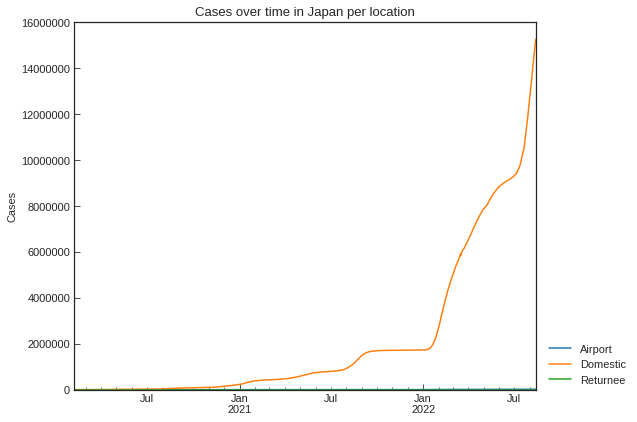

In [17]:
line_plot(location_df, "Cases over time in Japan per location", y_integer=True)

## Domestic: Tested, Confirmed, Recovered, Fatal

In [18]:
df = ncov_df.copy()
df = df.rename({"Positive": "Confirmed", "Discharged": "Recovered"}, axis=1)
df = df.loc[df["Location"] == "Domestic", ["Date", "Tested", "Confirmed", "Recovered", "Fatal"]]
df = df.groupby("Date").last()
main_df = df.copy()
main_df.tail()

,Tested,Confirmed,Recovered,Fatal
Date,,,,
2022-08-09,62739413,14400634,12328617,33817
2022-08-10,63062694,14597345,12524718,34067
2022-08-11,63572021,14840423,12779458,34315
2022-08-12,63767582,15065316,12938421,34529
2022-08-13,64129801,15257647,13185178,34755


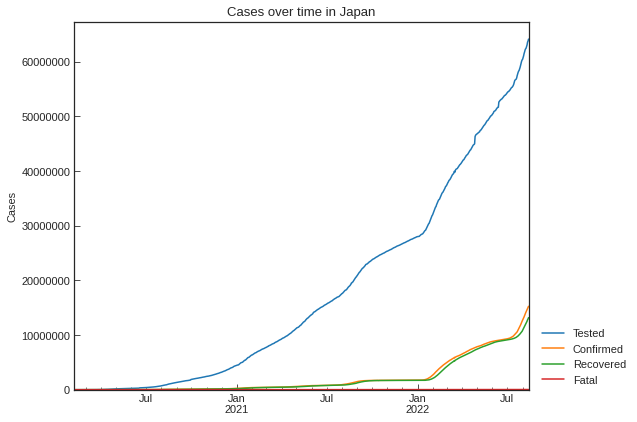

In [19]:
line_plot(main_df, "Cases over time in Japan", y_integer=True)

In [20]:
df = pd.DataFrame(main_df.loc["2020-03-22":"2020-03-26", "Tested"])
df.T.style.background_gradient(cmap="Wistia", axis=1)

Date,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-25 00:00:00,2020-03-26 00:00:00
Tested,18226,18322,22184,21266,22858


Value on 25Mar2020 is smaller than 24Mar2020, but this is correct.

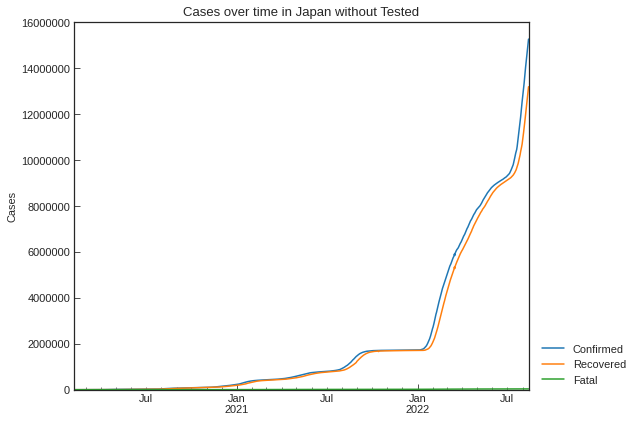

In [21]:
line_plot(main_df.drop("Tested", axis=1), "Cases over time in Japan without Tested", y_integer=True)

## Domestic: Symptomatic / Asymptomatic

In [22]:
df = ncov_df.copy()
df = df.loc[df["Location"] == "Domestic", ["Date", "Symptomatic", "Asymptomatic"]]
df = df.groupby("Date").last()
sym_df = df.copy()
sym_df.tail()

,Symptomatic,Asymptomatic
Date,,
2022-08-09,9224,1024
2022-08-10,9224,1024
2022-08-11,9224,1024
2022-08-12,9224,1024
2022-08-13,9224,1024


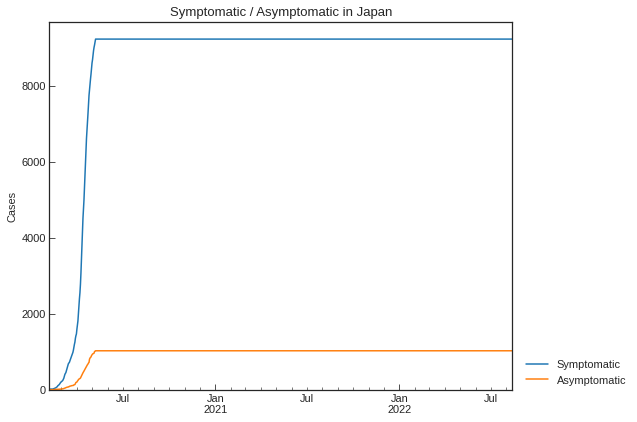

In [23]:
line_plot(sym_df, "Symptomatic / Asymptomatic in Japan", y_integer=True)

## Domestic: Severe / (Mild + Severe)

In [24]:
df = ncov_df.copy()
df = df.loc[df["Location"] == "Domestic", :]
df = df.groupby("Date").last()
df["Rate"] = df["Hosp_severe"] / (df["Hosp_mild"] + df["Hosp_severe"])
df = df.loc[:, ["Hosp_mild", "Hosp_severe", "Rate"]]
severe_df = df.copy()
severe_df.tail()

,Hosp_mild,Hosp_severe,Rate
Date,,,
2022-08-09,4974,581,0.104590
2022-08-10,4974,597,0.107162
2022-08-11,4974,603,0.108123
2022-08-12,4974,637,0.113527
2022-08-13,4974,625,0.111627


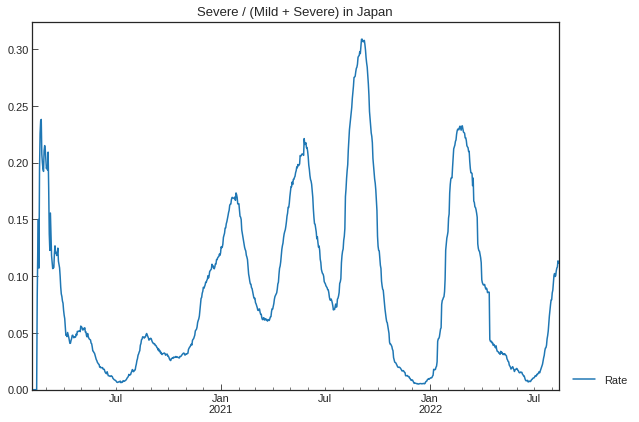

In [25]:
line_plot(severe_df["Rate"], "Severe / (Mild + Severe) in Japan", y_integer=True, ylabel=None)

## Domestic: Positive / Tested

In [26]:
df = ncov_df.copy()
df = df.loc[df["Location"] == "Domestic", :]
df = df.groupby("Date").last()
df["Rate"] = df["Positive"] / df["Tested"] * 100
df = df.loc[:, ["Positive", "Tested", "Rate"]]
positive_df = df.copy()
positive_df.tail()

,Positive,Tested,Rate
Date,,,
2022-08-09,14400634,62739413,22.953090
2022-08-10,14597345,63062694,23.147354
2022-08-11,14840423,63572021,23.344268
2022-08-12,15065316,63767582,23.625352
2022-08-13,15257647,64129801,23.791820


In [27]:
positive_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Positive,920.0,2.154699e+06,3.285949e+06,16.000000,7.876650e+04,6.400900e+05,1.726425e+06,1.525765e+07
Tested,920.0,1.780913e+07,1.802028e+07,132.000000,1.656256e+06,1.187570e+07,2.780030e+07,6.412980e+07
Rate,920.0,8.230602e+00,4.653082e+00,4.086476,5.139281e+00,6.175387e+00,9.688141e+00,2.379182e+01


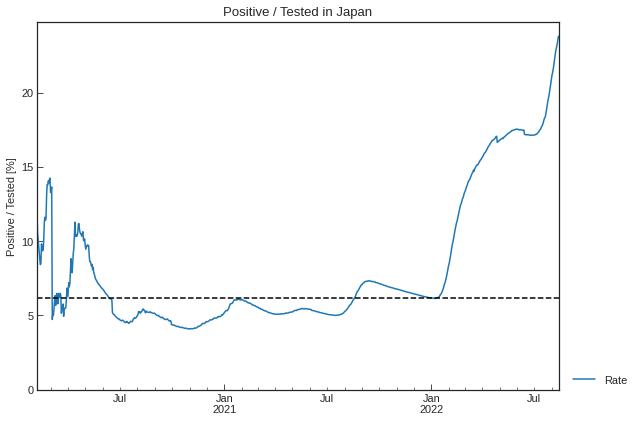

In [28]:
line_plot(
    positive_df["Rate"], "Positive / Tested in Japan",
    ylabel="Positive / Tested [%]",
    y_integer=True,
    h=positive_df["Rate"].median()
)

# Cumurative number of cases in each prefecture
covid_jpn_prefecture.csv

## Raw data

In [29]:
pref_raw = pd.read_csv("/kaggle/input/covid19-dataset-in-japan/covid_jpn_prefecture.csv")
pref_raw.tail()

,Date,Prefecture,Positive,Tested,Discharged,Fatal,Hosp_require,Hosp_severe
41261,2022-08-12,Kumamoto,229616,434793.0,198471.0,433.0,30712.0,15.0
41262,2022-08-12,Oita,114785,757715.0,99914.0,208.0,14663.0,2.0
41263,2022-08-12,Miyazaki,121626,218056.0,99444.0,209.0,21632.0,5.0
41264,2022-08-12,Kagoshima,186598,591022.0,154414.0,284.0,28992.0,4.0
41265,2022-08-12,Okinawa,413597,1074771.0,377778.0,537.0,34993.0,22.0


In [30]:
pref_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41266 entries, 0 to 41265
Data columns (total 8 columns):
Date            41266 non-null object
Prefecture      41266 non-null object
Positive        41266 non-null int64
Tested          41199 non-null float64
Discharged      41218 non-null float64
Fatal           40908 non-null float64
Hosp_require    38842 non-null float64
Hosp_severe     38586 non-null float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.5+ MB


In [31]:
pd.DataFrame(pref_raw.isna().sum()).T

,Date,Prefecture,Positive,Tested,Discharged,Fatal,Hosp_require,Hosp_severe
0,0,0,0,67,48,358,2424,2680


In [32]:
pprint(pref_raw["Prefecture"].unique().tolist(), compact=True)

['Hokkaido', 'Aomori', 'Iwate', 'Miyagi', 'Akita', 'Yamagata', 'Fukushima',
 'Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo', 'Kanagawa',
 'Niigata', 'Toyama', 'Ishikawa', 'Fukui', 'Yamanashi', 'Nagano', 'Gifu',
 'Shizuoka', 'Aichi', 'Mie', 'Shiga', 'Kyoto', 'Osaka', 'Hyogo', 'Nara',
 'Wakayama', 'Tottori', 'Shimane', 'Okayama', 'Hiroshima', 'Yamaguchi',
 'Tokushima', 'Kagawa', 'Ehime', 'Kochi', 'Fukuoka', 'Saga', 'Nagasaki',
 'Kumamoto', 'Oita', 'Miyazaki', 'Kagoshima', 'Okinawa']


## Data cleaning

In [33]:
df = pref_raw.copy()
df.dropna(how="all", inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
sel = df.columns.isin(["Date", "Prefecture"])
df = df.groupby("Prefecture").apply(
    lambda x: x.set_index("Date").resample("D").interpolate("linear")
)
df = df.fillna(0)
df = df.drop("Prefecture", axis=1).reset_index()
df = df.sort_values("Date").reset_index(drop=True)
sel = df.columns.isin(["Date", "Prefecture"])
df.loc[:, ~sel] = df.loc[:, ~sel].interpolate("linear").astype(np.int64)
pref_df = df.copy()
pref_df.tail()

,Prefecture,Date,Positive,Tested,Discharged,Fatal,Hosp_require,Hosp_severe
41261,Osaka,2022-08-12,1600385,8633862,1375077,5584,219724,70
41262,Ibaraki,2022-08-12,253810,1477266,229245,507,24058,8
41263,Okinawa,2022-08-12,413597,1074771,377778,537,34993,22
41264,Okayama,2022-08-12,170522,723970,140502,293,20921,11
41265,Yamanashi,2022-08-12,63378,443620,54163,89,9207,0


## Confirmed (PCR tested positive) cases

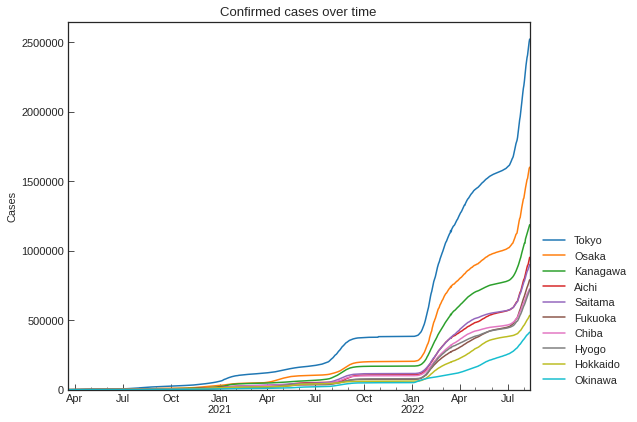

In [34]:
df = pref_df.pivot_table(
    index="Date", columns="Prefecture", values="Positive", aggfunc="last"
)
df = df.sort_values(by=df.index[-1], axis=1, ascending=False)
confirmed_top = df.columns[0]
line_plot(df.iloc[:, :10], "Confirmed cases over time", y_integer=True)

## Tested, Confirmed, Discharged, Fatal

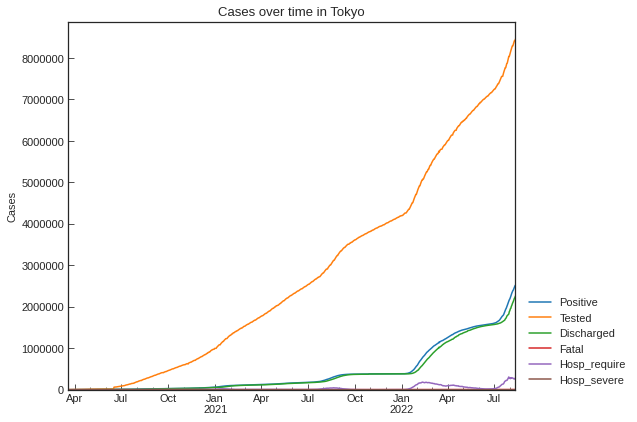

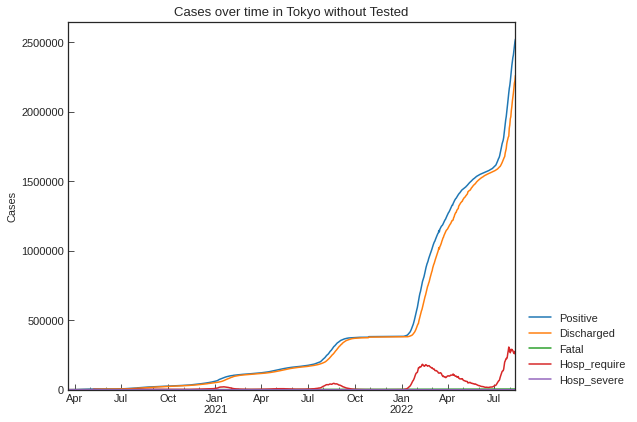

In [35]:
df = pref_df.copy()
df = df.loc[df["Prefecture"] == confirmed_top, :]
df = df.drop("Prefecture", axis=1).groupby("Date").last()
line_plot(df, f"Cases over time in {confirmed_top}", y_integer=True)
line_plot(df.drop("Tested", axis=1), f"Cases over time in {confirmed_top} without Tested", y_integer=True)

# Meta data
covid_jpn_metadata.csv

## Raw data

In [36]:
meta_raw = pd.read_csv("/kaggle/input/covid19-dataset-in-japan/covid_jpn_metadata.csv")
meta_raw.tail()

,Prefecture,Category,Item,Value,Date,Primary_source,Secondary_source
841,Kumamoto,Admin,Num,43,2012-04-27,http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html,NaN
842,Oita,Admin,Num,44,2012-04-27,http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html,NaN
843,Miyazaki,Admin,Num,45,2012-04-27,http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html,NaN
844,Kagoshima,Admin,Num,46,2012-04-27,http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html,NaN
845,Okinawa,Admin,Num,47,2012-04-27,http://nlftp.mlit.go.jp/ksj/gml/codelist/PrefCd.html,NaN


In [37]:
meta_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 7 columns):
Prefecture          846 non-null object
Category            846 non-null object
Item                846 non-null object
Value               846 non-null object
Date                846 non-null object
Primary_source      564 non-null object
Secondary_source    470 non-null object
dtypes: object(7)
memory usage: 46.4+ KB


In [38]:
pd.DataFrame(meta_raw.isna().sum()).T

,Prefecture,Category,Item,Value,Date,Primary_source,Secondary_source
0,0,0,0,0,0,282,376


## Data cleaning

In [39]:
meta_raw["Category"].unique().tolist()

['Population', 'Area', 'Hospital_bed', 'Clinic_bed', 'Location', 'Admin']

In [40]:
df = meta_raw.copy()
df["Title"] = df["Category"].str.cat(df["Item"], sep="_")
df = df.pivot_table(
    index="Prefecture", columns="Title", values="Value", aggfunc="last"
)
# Integer
cols = df.columns.str.startswith("Population")
cols += df.columns.str.startswith("Area")
cols += df.columns.str.startswith("Hospital_bed")
cols += df.columns.str.startswith("Clinic_bed")
df.loc[:, cols] = df.loc[:, cols].astype(np.int64)
df["Admin_Num"] = df["Admin_Num"].astype(np.int64)
# Numeric
cols = df.columns.str.startswith("Location")
df.loc[:, cols] = df.loc[:, cols].astype(np.float64)
# Sorting
df = df.loc[meta_raw["Prefecture"].unique(), :]
meta_df = df.copy()
meta_df.head()

Title,Admin_Capital,Admin_Num,Admin_Region,Area_Habitable,Area_Total,Clinic_bed_Care,Clinic_bed_Total,Hospital_bed_Care,Hospital_bed_Specific,Hospital_bed_Total,Hospital_bed_Tuberculosis,Hospital_bed_Type-I,Hospital_bed_Type-II,Location_Latitude,Location_Longitude,Population_Female,Population_Male,Population_Total
Prefecture,,,,,,,,,,,,,,,,,,
Hokkaido,Sapporo,1,Hokkaido,22373,83424,428,5585,20822,0,93050,153,2,92,43.065063,141.347644,2814,2506,5320
Aomori,Aomori,2,Tohoku,3230,9646,114,1906,2614,0,17075,33,1,28,40.824592,140.740031,678,600,1278
Iwate,Morioka,3,Tohoku,3714,15275,98,1255,2310,0,16557,91,2,36,39.703670,141.152717,651,604,1255
Miyagi,Sendai,4,Tohoku,3155,7282,91,1468,3431,0,25121,28,2,27,38.268915,140.872212,1188,1136,2323
Akita,Akita,5,Tohoku,3204,11638,77,721,2035,0,14627,44,2,30,39.718353,140.103416,528,468,996


In [41]:
meta_df.columns.tolist()

['Admin_Capital',
 'Admin_Num',
 'Admin_Region',
 'Area_Habitable',
 'Area_Total',
 'Clinic_bed_Care',
 'Clinic_bed_Total',
 'Hospital_bed_Care',
 'Hospital_bed_Specific',
 'Hospital_bed_Total',
 'Hospital_bed_Tuberculosis',
 'Hospital_bed_Type-I',
 'Hospital_bed_Type-II',
 'Location_Latitude',
 'Location_Longitude',
 'Population_Female',
 'Population_Male',
 'Population_Total']

## Total population, area $[\mathrm{km}^2]$, population density

In [42]:
df = meta_df.copy()
df["Density_All"] = df["Population_Total"] / df["Area_Total"]
df["Density_Habitable"] = df["Population_Total"] / df["Area_Habitable"]
cols = df.columns.str.startswith("Population")
cols += df.columns.str.startswith("Area")
cols += df.columns.str.startswith("Density")
df = df.loc[:, cols].sort_values("Density_Habitable", ascending=False)
pop_df = df.copy()
pop_df.head()

Title,Area_Habitable,Area_Total,Population_Female,Population_Male,Population_Total,Density_All,Density_Habitable
Prefecture,,,,,,,
Tokyo,1418,2191,6964,6760,13724,6.26381,9.67842
Osaka,1331,1905,4583,4241,8823,4.6315,6.62885
Kanagawa,1471,2416,4590,4569,9159,3.79098,6.22638
Saitama,2585,3798,3662,3648,7310,1.9247,2.82785
Aichi,2988,5172,3761,3764,7525,1.45495,2.51841


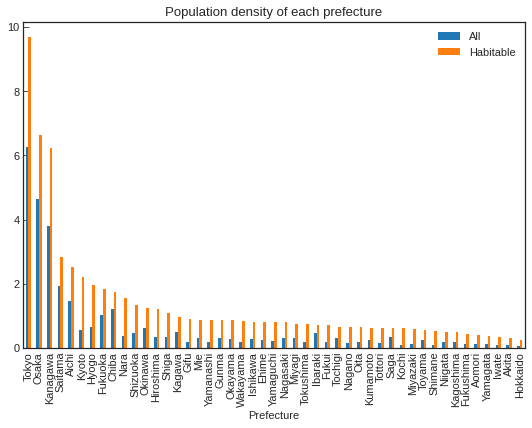

In [43]:
df = pop_df.loc[:, pop_df.columns.str.startswith("Density")]
df.columns = df.columns.str.replace("Density_", "")
df.plot.bar()
plt.title("Population density of each prefecture")
plt.legend(title=None)
plt.show()

## Beds of hospitals and clinics

In [44]:
df = meta_df.copy()
cols = df.columns.str.startswith("Hospital_bed")
cols += df.columns.str.startswith("Clinic_bed")
df = df.loc[:, cols]
df.head()

Title,Clinic_bed_Care,Clinic_bed_Total,Hospital_bed_Care,Hospital_bed_Specific,Hospital_bed_Total,Hospital_bed_Tuberculosis,Hospital_bed_Type-I,Hospital_bed_Type-II
Prefecture,,,,,,,,
Hokkaido,428,5585,20822,0,93050,153,2,92
Aomori,114,1906,2614,0,17075,33,1,28
Iwate,98,1255,2310,0,16557,91,2,36
Miyagi,91,1468,3431,0,25121,28,2,27
Akita,77,721,2035,0,14627,44,2,30


In [45]:
df = meta_df.copy()
df["Bed_for_severe"] = df["Hospital_bed_Specific"] + df["Hospital_bed_Type-I"] + df["Hospital_bed_Type-II"]
df["Bed_for_other"] = df["Hospital_bed_Total"] - df["Bed_for_severe"] + df["Clinic_bed_Total"]
bed_df = df.copy()
bed_df.head()

Title,Admin_Capital,Admin_Num,Admin_Region,Area_Habitable,Area_Total,Clinic_bed_Care,Clinic_bed_Total,Hospital_bed_Care,Hospital_bed_Specific,Hospital_bed_Total,Hospital_bed_Tuberculosis,Hospital_bed_Type-I,Hospital_bed_Type-II,Location_Latitude,Location_Longitude,Population_Female,Population_Male,Population_Total,Bed_for_severe,Bed_for_other
Prefecture,,,,,,,,,,,,,,,,,,,,
Hokkaido,Sapporo,1,Hokkaido,22373,83424,428,5585,20822,0,93050,153,2,92,43.065063,141.347644,2814,2506,5320,94,98541
Aomori,Aomori,2,Tohoku,3230,9646,114,1906,2614,0,17075,33,1,28,40.824592,140.740031,678,600,1278,29,18952
Iwate,Morioka,3,Tohoku,3714,15275,98,1255,2310,0,16557,91,2,36,39.703670,141.152717,651,604,1255,38,17774
Miyagi,Sendai,4,Tohoku,3155,7282,91,1468,3431,0,25121,28,2,27,38.268915,140.872212,1188,1136,2323,29,26560
Akita,Akita,5,Tohoku,3204,11638,77,721,2035,0,14627,44,2,30,39.718353,140.103416,528,468,996,32,15316


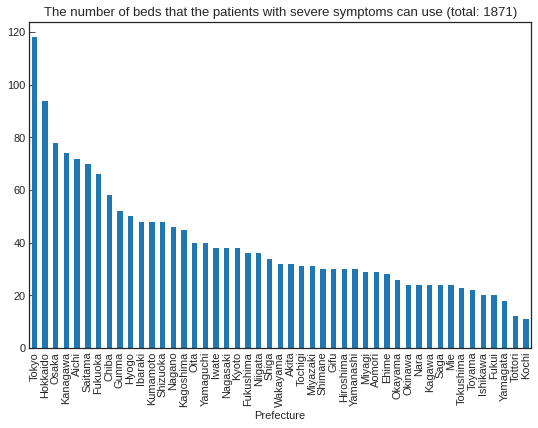

In [46]:
bed_df["Bed_for_severe"].sort_values(ascending=False).plot.bar()
total = bed_df["Bed_for_severe"].sum()
plt.title(f"The number of beds that the patients with severe symptoms can use (total: {total})")
plt.show()

## Administrative information and (Latitude, Longitude)

In [47]:
df = meta_df.copy()
cols = df.columns.str.startswith("Admin")
cols += df.columns.str.startswith("Location")
df = df.loc[:, cols]
admin_df = df.copy()
admin_df.head()

Title,Admin_Capital,Admin_Num,Admin_Region,Location_Latitude,Location_Longitude
Prefecture,,,,,
Hokkaido,Sapporo,1,Hokkaido,43.065063,141.347644
Aomori,Aomori,2,Tohoku,40.824592,140.740031
Iwate,Morioka,3,Tohoku,39.703670,141.152717
Miyagi,Sendai,4,Tohoku,38.268915,140.872212
Akita,Akita,5,Tohoku,39.718353,140.103416


In [48]:
df = pref_df.groupby("Prefecture").last()
df = pd.concat([admin_df, df], axis=1, sort=False)
admin_pref_df = df.copy()
admin_pref_df

,Admin_Capital,Admin_Num,Admin_Region,Location_Latitude,Location_Longitude,Date,Positive,Tested,Discharged,Fatal,Hosp_require,Hosp_severe
Hokkaido,Sapporo,1,Hokkaido,43.065063,141.347644,2022-08-12,534520,2684444,472552,2225,58313,8
Aomori,Aomori,2,Tohoku,40.824592,140.740031,2022-08-12,104698,323646,90901,153,13644,0
Iwate,Morioka,3,Tohoku,39.703670,141.152717,2022-08-12,67131,370919,57642,125,9364,0
Miyagi,Sendai,4,Tohoku,38.268915,140.872212,2022-08-12,168373,749558,137304,240,28785,10
Akita,Akita,5,Tohoku,39.718353,140.103416,2022-08-12,56832,69427,43221,83,13528,3
Yamagata,Yamagata,6,Tohoku,38.240354,140.362582,2022-08-12,54348,219141,43417,113,10828,1
Fukushima,Fukushima,7,Tohoku,37.750324,140.466769,2022-08-12,104996,983888,88135,235,16626,4
Ibaraki,Mito,8,Kanto,36.341981,140.446792,2022-08-12,253810,1477266,229245,507,24058,8
Tochigi,Utsunomiya,9,Kanto,36.565875,139.883507,2022-08-12,156382,856344,128388,333,27661,7
Gunma,Maebashi,10,Kanto,36.391389,139.060852,2022-08-12,157580,783045,115007,367,46580,2


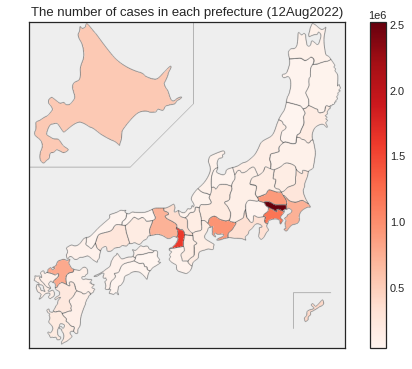

In [49]:
# Usage if japanmap package (in Japanese):
# https://qiita.com/SaitoTsutomu/items/6d17889ba47357e44131
df = admin_pref_df.copy()
df.index = df["Admin_Num"].apply(lambda x: japanmap.pref_names[x])
cmap = plt.get_cmap("Reds")
norm = plt.Normalize(vmin=df["Positive"].min(), vmax=df["Positive"].max())
fcol = lambda x: "#" + bytes(cmap(norm(x), bytes=True)[:3]).hex()
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.colorbar(plt.cm.ScalarMappable(norm, cmap))
plt.imshow(japanmap.picture(df["Positive"].apply(fcol)))
plt.title(f"The number of cases in each prefecture ({df['Date'].max().strftime('%d%b%Y')})")
plt.show()

## Prefecture code dictionary
If you want to know the location of the prefectures, plese refer to [Japan Visitor: Japan Prefectures Map](https://www.japanvisitor.com/japan-travel/prefectures-map).

In [50]:
pref_code_dict = meta_df["Admin_Num"].to_dict()
pprint(list(pref_code_dict.items()), width=60, compact=True)

[('Hokkaido', 1), ('Aomori', 2), ('Iwate', 3),
 ('Miyagi', 4), ('Akita', 5), ('Yamagata', 6),
 ('Fukushima', 7), ('Ibaraki', 8), ('Tochigi', 9),
 ('Gunma', 10), ('Saitama', 11), ('Chiba', 12),
 ('Tokyo', 13), ('Kanagawa', 14), ('Niigata', 15),
 ('Toyama', 16), ('Ishikawa', 17), ('Fukui', 18),
 ('Yamanashi', 19), ('Nagano', 20), ('Gifu', 21),
 ('Shizuoka', 22), ('Aichi', 23), ('Mie', 24),
 ('Shiga', 25), ('Kyoto', 26), ('Osaka', 27), ('Hyogo', 28),
 ('Nara', 29), ('Wakayama', 30), ('Tottori', 31),
 ('Shimane', 32), ('Okayama', 33), ('Hiroshima', 34),
 ('Yamaguchi', 35), ('Tokushima', 36), ('Kagawa', 37),
 ('Ehime', 38), ('Kochi', 39), ('Fukuoka', 40),
 ('Saga', 41), ('Nagasaki', 42), ('Kumamoto', 43),
 ('Oita', 44), ('Miyazaki', 45), ('Kagoshima', 46),
 ('Okinawa', 47)]
